In [34]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import seaborn as sns
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [19]:
df = pd.read_csv('C:/Users/84909/Finpros/datasets/FPT.csv', index_col ="Date/Time")

In [20]:
date_format = "%m/%d/%Y %H:%M"
df.index = pd.to_datetime(df.index, format = date_format)

df.head(5)

,Open,High,Low,Close,Volume
Date/Time,,,,,
2018-12-25 09:15:00,30.89,30.89,30.89,30.89,35410
2018-12-25 09:16:00,30.81,30.81,30.81,30.81,190
2018-12-25 09:17:00,30.74,30.81,30.74,30.74,1120
2018-12-25 09:18:00,30.74,30.74,30.74,30.74,2120
2018-12-25 09:19:00,30.74,30.74,30.74,30.74,22500


In [21]:
df = df.resample('1D').mean().dropna()

In [22]:
df['Return'] = 100 * (df['Close'].pct_change())
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Volume,Return
Date/Time,,,,,,
2018-12-26,31.048016,31.054683,31.042857,31.050159,2647.539683,0.943299
2018-12-27,31.332537,31.335821,31.327313,31.331567,3394.477612,0.906303
2018-12-28,31.322213,31.326803,31.318525,31.321557,3173.524590,-0.031948
2019-01-02,31.231709,31.238376,31.224188,31.232393,3924.102564,-0.284674
2019-01-03,30.579669,30.583867,30.572155,30.578619,3959.116022,-2.093257


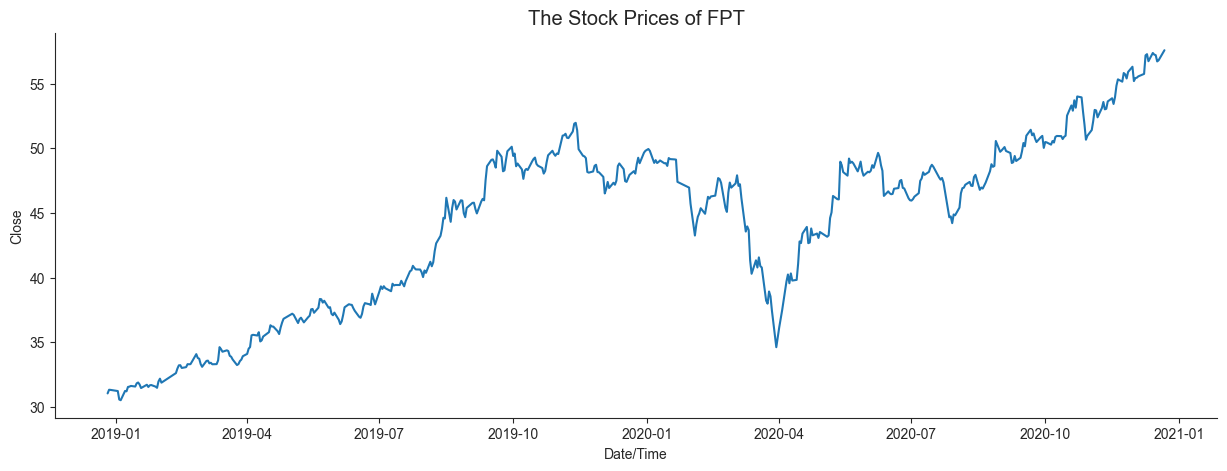

In [23]:
plt.figure(figsize=(15, 5))
sns.set_style("ticks")
sns.lineplot(data = df, x = "Date/Time", y = 'Close')
plt.title("The Stock Prices of FPT",size = 'x-large')
sns.despine()
plt.show()

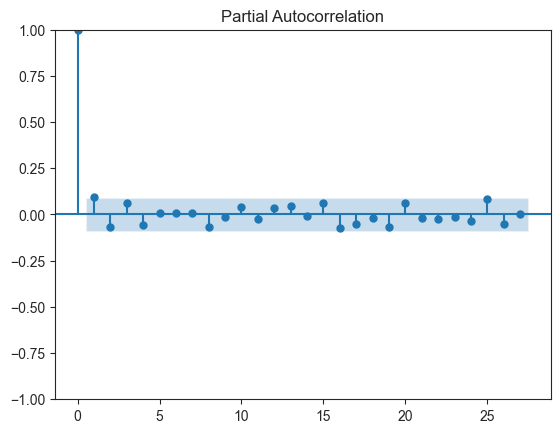

In [15]:
plot_pacf(df['log_returns'])
plt.show()

In [24]:
daily_volatility = df['Return'].std()
print('Daily volatility: ', '{:.2f}%'.format(daily_volatility))
monthly_volatility = np.sqrt(21) * daily_volatility
print('Monthly volatility: ', '{:.2f}%'.format(monthly_volatility))
annual_volatility = np.sqrt(252) * daily_volatility
print('Annual volatility: ', '{:.2f}%'.format(annual_volatility))

Daily volatility:  1.43%
Monthly volatility:  6.54%
Annual volatility:  22.67%


In [26]:
garch_model = arch_model(df['Return'], p=1, q=1,
                         mean='constant', vol='GARCH', dist='normal')
gm_result = garch_model.fit(disp='off')
print(gm_result.params)

mu          0.158970
omega       0.042400
alpha[1]    0.051012
beta[1]     0.926892
Name: params, dtype: float64


In [27]:
print('\n')
gm_forecast = gm_result.forecast(horizon=5)
print(gm_forecast.variance[-1:])



                 h.1       h.2       h.3       h.4       h.5
Date/Time                                                   
2020-12-22  1.155464  1.172332  1.188828  1.204959  1.220733


In [30]:
rolling_predictions = []
test_size = 365
for i in range(test_size):
    train = df['Return'][:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [31]:
rolling_predictions = pd.Series(rolling_predictions, index=df['Return'].index[-365:])

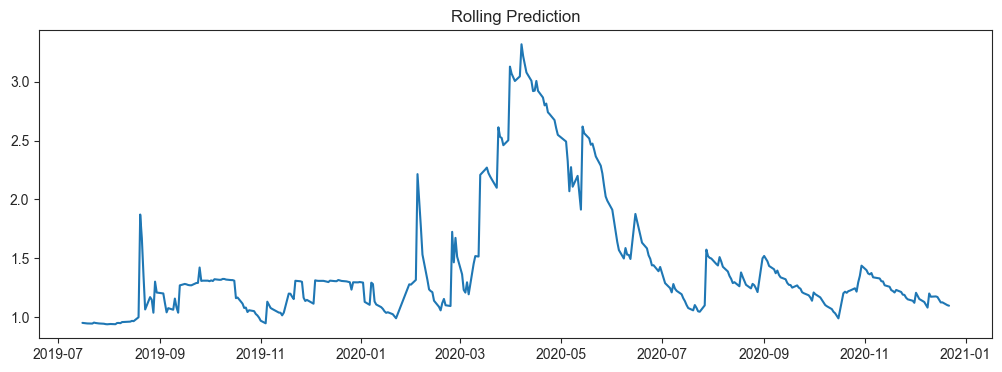

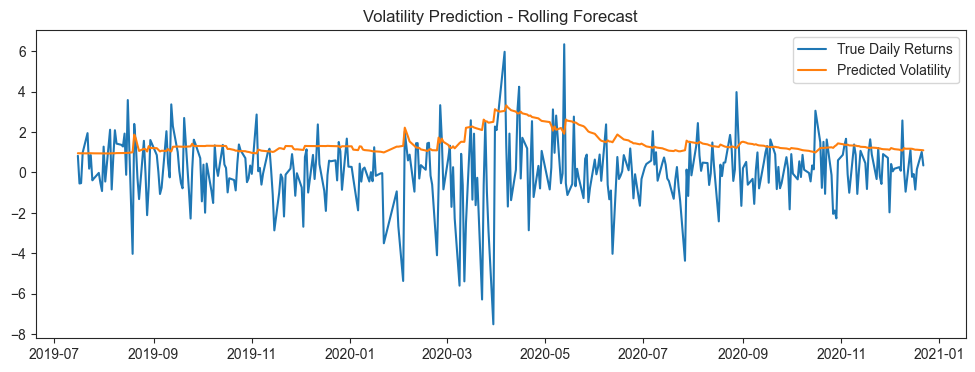

In [32]:
plt.figure(figsize=(12.3,4))
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')
plt.show()
plt.figure(figsize=(12,4))
plt.plot(df['Return'][-365:])
plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast')
plt.legend(['True Daily Returns', 'Predicted Volatility'])
plt.show()

In [47]:
X = df['Close']
size = -365
train, test = X[0:size], X[size:]

In [48]:
model = auto_arima(train, start_p=0, start_q=0,
                   max_p=8, max_q=8, m=12,
                   start_P=0, seasonal=False,
                   d=1, D=0, trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=90.119, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=91.478, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=91.075, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=92.769, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=88.738, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=88.784, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=86.309, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=88.280, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=90.296, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.398 seconds


In [49]:
# Define the ARIMA model
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(1,0,1))
    model_fit = model.fit()
    # Make the prediction
    output = model_fit.forecast(step = 1)
    yhat = output[0]
    return yhat

In [50]:
# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

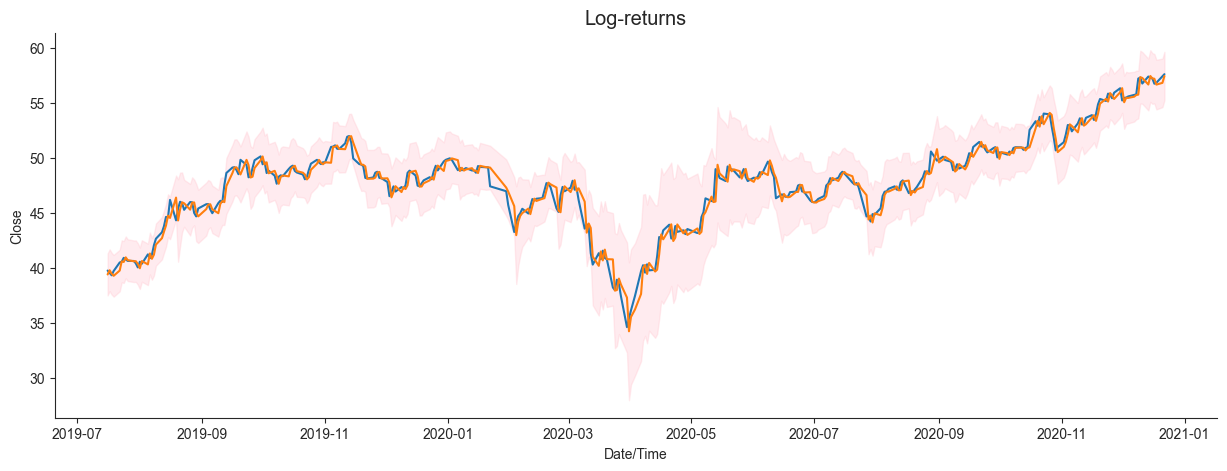

In [54]:
plt.figure(figsize=(15, 5))
sns.set_style("ticks")
sns.lineplot(data = df[-365:], x = "Date/Time", y = 'Close')
sns.lineplot(data = df[-365:], x = "Date/Time", y = predictions)
plt.fill_between(df[-365:].index, predictions - 2*rolling_predictions, predictions + 2*rolling_predictions, color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title("Log-returns",size = 'x-large')
sns.despine()
plt.show()